In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , accuracy_score, roc_auc_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#reading csv file into dataframe
df = pd.read_csv("/content/drive/MyDrive/fraud_detection/Fraud.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


**DATA VALIDATION AND FEATURE ENGINEERING**

In [ ]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
df["isFraud"].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

Dataset is highly unbalance , as expected.

In [ ]:
df.groupby("isFraud").mean()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
isFraud,,,,,,,
0,243.235663,1.781970e+05,8.328287e+05,855970.228109,1.101421e+06,1.224926e+06,0.000000
1,368.413856,1.467967e+06,1.649668e+06,192392.631836,5.442496e+05,1.279708e+06,0.001948


It can be noticed that incase of faurdulent transaction the new balance of orginisation has dipped quit significantly, and Fraudesters bank balance have shot up.

The sample size of our dataset is really big, we have more than 6 million records. Due to time constraint I have to down sample to balance our dataset, oversampling and weight calibration will take longer.

In [ ]:
legit = df[df.isFraud == 0]
fraud = df[df.isFraud == 1]
legit_sample = legit.sample(n=8213)
df= pd.concat([legit_sample, fraud], axis = 0)
df["isFraud"].value_counts()

1    8213
0    8213
Name: isFraud, dtype: int64

In [ ]:
#converting "type" column into numerical code
Trax_type = df["type"].unique()
type_dict = {}
for i,value in enumerate(Trax_type):
    type_dict[value] = i
type_dict

df["type"] = df.type.apply(lambda x: type_dict[x])
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3387288,255,0,75083.71,C584800520,0.00,0.00,C1261329785,3127168.72,3202252.43,0,0
2116552,183,0,127807.67,C1617984648,30391.00,0.00,C369400196,441679.27,569486.94,0,0
3093002,235,1,74412.54,C1088724867,18013963.64,18088376.18,C333444083,1332181.05,1257768.51,0,0
1572075,155,0,387180.11,C1823283147,61329.00,0.00,C1263724469,3131447.63,3518627.73,0,0
3253518,251,2,17422.04,C835450058,322238.00,304815.96,M109538265,0.00,0.00,0,0


In [ ]:
#converting "nameDest" and "nameOrig" into numerical code.
#slicing first character of the name out.
df["nameDest"] = df["nameDest"].str.slice(start = 0 , stop = 1)
df["nameOrig"] = df["nameOrig"].str.slice(start = 0 , stop = 1)
name_dict = {"C":0, "M" : 1}
df["nameDest"] = df.nameDest.apply(lambda x: name_dict[x])
df["nameOrig"] = df.nameOrig.apply(lambda x: name_dict[x])
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3387288,255,0,75083.71,0,0.00,0.00,0,3127168.72,3202252.43,0,0
2116552,183,0,127807.67,0,30391.00,0.00,0,441679.27,569486.94,0,0
3093002,235,1,74412.54,0,18013963.64,18088376.18,0,1332181.05,1257768.51,0,0
1572075,155,0,387180.11,0,61329.00,0.00,0,3131447.63,3518627.73,0,0
3253518,251,2,17422.04,0,322238.00,304815.96,1,0.00,0.00,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


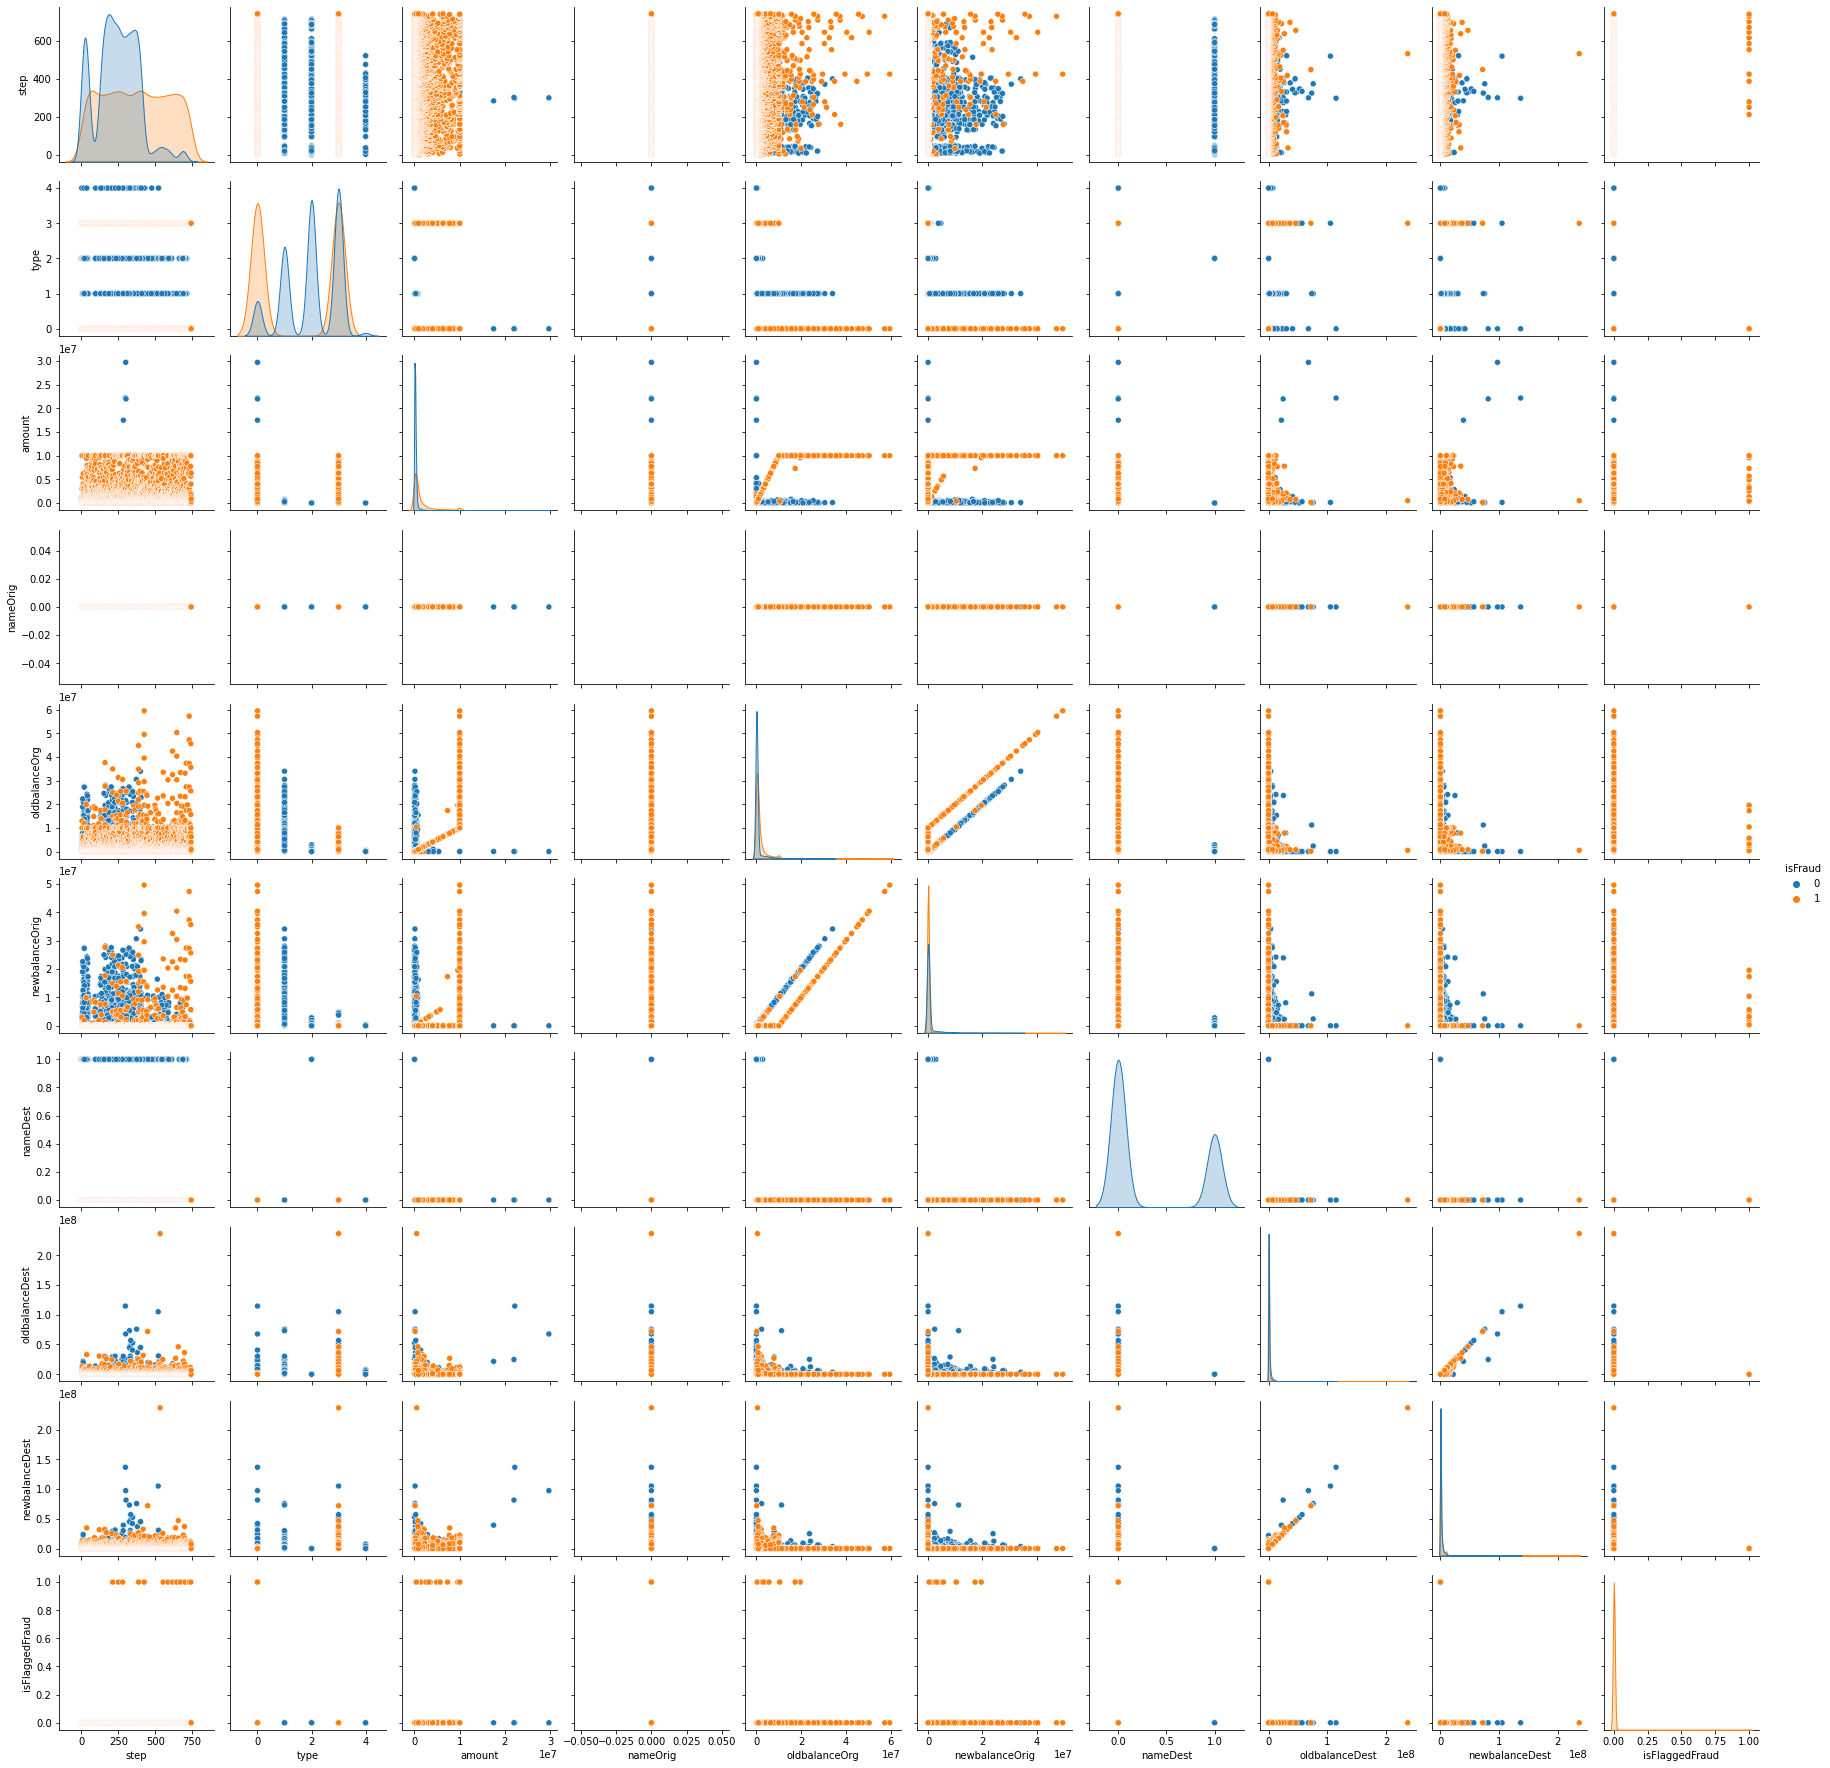

In [ ]:
#feature wise pairplot
sns.pairplot(df,hue="isFraud")

there is a good linear seperation for some features in our data, a linear model will fit well but some features are non-linearly seperable so we have to see how our linear and non linear model performs

In [ ]:
#correlation among features
df.corr()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.043876,0.148991,NaN,0.074758,-0.021541,-0.140834,-0.013884,0.024867,0.323636,0.037391
type,0.043876,1.000000,0.058735,NaN,0.031597,0.005164,0.230378,-0.150866,-0.232032,0.117771,0.039932
amount,0.148991,0.058735,1.000000,NaN,0.636252,0.119466,-0.197086,0.014069,0.297956,0.344416,0.067398
nameOrig,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldbalanceOrg,0.074758,0.031597,0.636252,NaN,1.000000,0.827945,-0.163343,0.010736,0.130954,0.121249,0.062418
newbalanceOrig,-0.021541,0.005164,0.119466,NaN,0.827945,1.000000,-0.083669,0.042943,0.004266,-0.134014,0.089231
nameDest,-0.140834,0.230378,-0.197086,NaN,-0.163343,-0.083669,1.000000,-0.121705,-0.161546,-0.454772,-0.014200
oldbalanceDest,-0.013884,-0.150866,0.014069,NaN,0.010736,0.042943,-0.121705,1.000000,0.903261,-0.084936,-0.008356
newbalanceDest,0.024867,-0.232032,0.297956,NaN,0.130954,0.004266,-0.161546,0.903261,1.000000,0.014632,-0.011092
isFraud,0.323636,0.117771,0.344416,NaN,0.121249,-0.134014,-0.454772,-0.084936,0.014632,1.000000,0.031225


since nameOrig is of no use, we will drop it as it will increase the varience in our pridictions.

In [ ]:
X = df.drop(columns = ["isFraud","nameOrig"])
y = df["isFraud"]
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud
3387288,255,0,75083.71,0.00,0.00,0,3127168.72,3202252.43,0
2116552,183,0,127807.67,30391.00,0.00,0,441679.27,569486.94,0
3093002,235,1,74412.54,18013963.64,18088376.18,0,1332181.05,1257768.51,0
1572075,155,0,387180.11,61329.00,0.00,0,3131447.63,3518627.73,0
3253518,251,2,17422.04,322238.00,304815.96,1,0.00,0.00,0


In [ ]:
# Randomly spliting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33,random_state=3)

In [ ]:
# Normalising
scaler = StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

**CREATING MODELS**

In [ ]:
# Model 1 with random forest classifier
rfc = RandomForestClassifier(n_estimators=150)
rfc.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
#metrics
training_rfc_accuracy = rfc.score(X_train_transformed, y_train)
testing_rfc_accuracy = rfc.score(X_test_transformed, y_test)

print("Training RFC Accuracy:", training_rfc_accuracy)
print("Testing RFC Accuracy:", testing_rfc_accuracy )

Training RFC Accuracy: 1.0
Testing RFC Accuracy: 0.991883416343848


In [ ]:
#confusion_matrix
TN, FP, FN, TP = confusion_matrix(y_test, rfc.predict(X_test_transformed)).flatten()
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)
print("True Positives:", TP)

sensitivity = TP/(TP + FN)
specificity = TN/(TN + FP)
precision = TP/(TP + FP)
print("\nSensitivity:", sensitivity)
print("Specificity:", specificity)
print("Precision:", precision)

True Negatives: 2701
False Positives: 34
False Negatives: 10
True Positives: 2676

Sensitivity: 0.996276991809382
Specificity: 0.9875685557586837
Precision: 0.9874538745387453


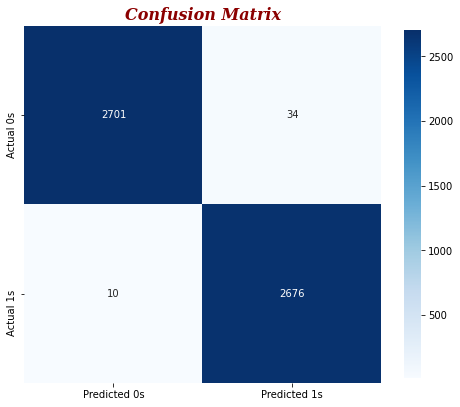

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
font1 = {'family': 'serif', 
        'fontstyle': 'italic',
        'fontsize': 16,
        'fontweight': 'bold',
        'color': 'DarkRed'}
font2 = {'weight': 'bold', 'size': 12}

sns.heatmap(confusion_matrix(y_test, rfc.predict(X_test_transformed)), 
            cmap='Blues', 
            square=True,
            annot=True,
            fmt='d',
            cbar_kws={'shrink': 0.8},
            xticklabels=['Predicted 0s', 'Predicted 1s'],
            yticklabels=['Actual 0s', 'Actual 1s'])
ax.set_title('Confusion Matrix', fontdict=font1)
plt.show()

In [ ]:
# Check the predicted probabilities for every observation in the test data subset 
# Note that the default classification threshold is 0.5

testing_probabilities= rfc.predict_proba(X_test)
testing_probabilities

array([[0.48666667, 0.51333333],
       [0.44666667, 0.55333333],
       [0.46      , 0.54      ],
       ...,
       [0.46      , 0.54      ],
       [0.44666667, 0.55333333],
       [0.65333333, 0.34666667]])

As we can see from the above result, the matrix of probabilities being returned indicates the predicted class is equal to 0 or 1. In this matrix, each each row corresponds to a single observation: The first column is the probability of the predicted output being zero(non-fraud), that is 1 - 𝑝(𝑥_test), and the second column is the probability that the output is one(fraud), or 𝑝(𝑥_test).

In [ ]:
# Convert the testing probabilities into a dataframe
testing_probabilities_df = pd.DataFrame(testing_probabilities, columns=['1 - 𝑝(X_test)', '𝑝(X_test)'])
testing_probabilities_df.head()

,1 - 𝑝(X_test),𝑝(X_test)
0,0.486667,0.513333
1,0.446667,0.553333
2,0.460000,0.540000
3,0.673333,0.326667
4,0.653333,0.346667


In [ ]:
# Model evaluation -AUC
# Calculate AUC for both training and testing subsets
# Only probabilities being in the positive class is needed for the calculation, that is the second column
training_rfc_AUC = roc_auc_score(y_train, rfc.predict_proba(X_train_transformed)[:, 1]) 
testing_rfc_AUC = roc_auc_score(y_test, rfc.predict_proba(X_test_transformed)[:, 1])

print("Training RFC AUC:", training_rfc_AUC)
print("Testing RFC AUC:", testing_rfc_AUC)


Training RFC AUC: 1.0
Testing RFC AUC: 0.9992704401317142


In [ ]:
# Model 2 using logistic regression from statsmodels
log_reg = sm.Logit(y_train, X_train_transformed).fit()

         Current function value: 0.116071
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
# printing the summary table
print(log_reg.summary())


                           Logit Regression Results                           
Dep. Variable:                isFraud   No. Observations:                11005
Model:                          Logit   Df Residuals:                    10996
Method:                           MLE   Df Model:                            8
Date:                Mon, 23 Aug 2021   Pseudo R-squ.:                  0.8325
Time:                        16:35:18   Log-Likelihood:                -1277.4
converged:                      False   LL-Null:                       -7628.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4384      0.052      8.491      0.000       0.337       0.540
x2             0.5030      0.052      9.642      0.000       0.401       0.605
x3           -50.5207      3.296    -15.326      0.0

In [ ]:
#matrics
yhat = log_reg.predict(X_test_transformed)
prediction = list(map(round, yhat))
cm = confusion_matrix(y_test, prediction) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction))

Confusion Matrix : 
 [[2594  141]
 [  54 2632]]
Test accuracy =  0.9640287769784173


/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Not as good as random forest which is evident as features and target have non-linear relationship But it will help us learn which features have significant impact on our target variable

Our model is able to explain 83% of variance and most strong features are 4th "oldbalanceOrg" and 5th "newbalanceOrig". Since "nameDest" and "isFlaggedFraud" are not statistically significant, we will start by droping the "nameDest" first and fitting our logistic model again. lets find out how our model performed.

In [ ]:
#droping "nameDest" and re-fitting
X = df.drop(columns = ["isFraud","nameOrig","nameDest"])
y = df["isFraud"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33,random_state=3)
scaler = StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)
log_reg = sm.Logit(y_train, X_train_transformed).fit()
print(log_reg.summary())


         Current function value: 0.212366
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                isFraud   No. Observations:                11005
Model:                          Logit   Df Residuals:                    10997
Method:                           MLE   Df Model:                            7
Date:                Mon, 23 Aug 2021   Pseudo R-squ.:                  0.6936
Time:                        11:14:44   Log-Likelihood:                -2337.1
converged:                      False   LL-Null:                       -7628.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4690      0.039     12.173      0.000       0.393       0.545
x2            -0.5850      0.049    -12.006      0.000      -0.68

/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
yhat = log_reg.predict(X_test_transformed)
prediction = list(map(round, yhat))
cm = confusion_matrix(y_test, prediction) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction))

Confusion Matrix : 
 [[2682   53]
 [ 216 2470]]
Test accuracy =  0.9503781590112526


so after dropping the statistically irrelevant column "nameDest" , our model degraded but still managed to score 95% test accuracy.
which suggest we need further feature engineering to fit a logistical model or this model is not a good match. Thus we should go with non-linear model for better control over false positives and false negetives.

**Conclusion** :
Our first Random forest did well in lowering False positives and false negetives as well. We want lower false negetives. Our logistic model shows us that the **before and after bank balance of customer , Type of  transaction** are very important in identifying frauds. They show strong causal behaviour.

**Recommendation**:
As it is clear that fraudsters tries to take out as much as money possible in a single go, we should flag every large proportional transaction which leads to very small bank balance of our customer especially when this is the first transaction between customer and third party. 

1. look out for large transactions leaving small balance.
2. if condition 1 is met, check whether its the first time transaction.
3. check if the third party is not Merchant account.

**System management**:
1. Randomly talking on call to customers who's transaction has been flagged.
2. Continous monitoring of customer complaints.
3. We should implement CI/CD/CT approach for our model on some cloud platform
like GCP or AWS..

